<center>
    <h1>Human Value Detection - BERT</h1>
    <h2>Bonini Roberto, Maidana Facundo Nicolas</h2>
    <h3>roberto.bonini@studio.unibo.it, facundo.maidana@studio.unibo.it</h3>
</center>

This notebook demonstrates how to use the **BERT Transformer** for multi-label classification of arguments. The task is to predict the labels associated with each argument based on its text.

We will use the Human Value Dataset which consists of argumentative sentences with annotations of argument components, such as premises and conclusion. We will focus on the task of multi-label classification of argument labels.

## Requirements

In order to execute our script, we need to import the necessary libraries and modules.

- **Pandas**: This library is used for data manipulation and analysis.
- **Transformers**: This library provides a high-level API for using BERT and other transformer-based models. It includes pre-trained models, tokenizers, and other utilities to make it easy to fine-tune these models for this specific NLP tasks.
- **Pytorch**: This library provides a flexible and dynamic approach to building deep learning models. It is used to model the models.
- **PyTorch Lightning**: This library that provides a lightweight and scalable interface for PyTorch. It simplifies the training process of deep learning models by abstracting away the low-level implementation details.

To take advantage of GPU accelerator to compute the training and inferences much faster.

Additionally, we have set the random seed to 42, which will ensure that our experiments can be reproduced exactly. By setting a fixed seed, we can ensure that our results are consistent and reliable, even when running the same experiment multiple times.

In [8]:
!nvidia-smi

Sun Apr  9 17:34:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip install wandb -qU

In [10]:
!pip install --quiet transformers pytorch-lightning sentencepiece sacremoses "ray[tune]" pytorch-lightning-bolts optuna wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.5 MB/s eta 0

In [11]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%cd /content
!rm -r human-value-detection
!git clone https://github.com/maidacundo/human-value-detection.git
%cd human-value-detection

/content
Cloning into 'human-value-detection'...
remote: Enumerating objects: 727, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 727 (delta 39), reused 46 (delta 22), pack-reused 662
Receiving objects: 100% (727/727), 578.40 KiB | 10.33 MiB/s, done.
Resolving deltas: 100% (438/438), done.
/content/human-value-detection


### Imports

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/human-value-detection')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl

from torchmetrics import Accuracy

from utils import seed
from utils.data import get_processed_df, perform_data_augmentation, HumanValuesDataset, HumanValuesDataModule
from plotting.data_analysis import plot_classification_reports
from models.baseline import TransformerClassifier
from utils.hyperparameters_tuning import HyperparameterTuner

from utils.thresholding import ThresholdModel, SurrogateHeaviside, train_thresholding_model, get_f1_optimized_thresholding, print_classification_report_thresholding

from sklearn.metrics import classification_report, multilabel_confusion_matrix

from IPython.core.display import clear_output

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from torch.utils.data import DataLoader
from torch import utils

from transformers import MarianMTModel, AutoTokenizer
from pytorch_lightning.loggers import WandbLogger

from functools import partial
import wandb

In [15]:
RANDOM_STATE = 42
seed.fix_random(RANDOM_STATE)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [16]:
device = "cpu"
if torch.cuda.is_available:
  print('Running on GPU')
  device = torch.device("cuda:0")  
else:
  print('Running on CPU, please set GPU.')

Running on GPU


## Data

For our task, we will need to prepare the data for fine-tuning our BERT model. We assume that the data files `arguments-train.tsv`, `labels-train.tsv`, `arguments-validation.tsv`, and `labels-validation.tsv` have already been downloaded and saved in our data folder.

To load the data, we will import each file into a separate `DataFrame`. Then, we will merge the arguments and labels DataFrame for each corresponding split (train and validation). We will take the values of all categories and convert them into a list.

This process will allow us to create a dataset that can be easily used for fine-tuning our BERT model.

In [17]:
DATA_ROOT_FOLDER = 'data'

arguments_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-training.tsv', delimiter='\t')
labels_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-training.tsv', delimiter='\t')

arguments_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-validation.tsv', delimiter='\t')
labels_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-validation.tsv', delimiter='\t')

arguments_test = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-test.tsv', delimiter='\t')

In [18]:
df_train_original = arguments_train.merge(labels_train)
df_test_original = arguments_val.merge(labels_val)

In [19]:
labels_columns = labels_train.drop('Argument ID', axis=1).columns

### Data Augmentation

To tackle the imbalance, we try *upsampling* the minority class. 

The algorithm is implemented in order to perform an augmentation in order to balance the support difference between labels in the dataset.

The labels are divided into `low support labels`, with a support $<800$ and `high support labels`, with a support $>800$.

For the augmentation, the rows to be augmented are choosen as follows:
- At least one `low support label` for the argument
- At maximum $2$ `high support label` for the argument


In [ ]:
low_support_columns = []
total_count = labels_train[labels_columns].sum()
for i, count in enumerate(total_count):
    if count<=800:
        low_support_columns.append(total_count.index[i])

high_support_columns = []
total_count = labels_train[labels_columns].sum()
for i, count in enumerate(total_count):
    if count>800:
        high_support_columns.append(total_count.index[i])

In [ ]:
df_train_aumentation = df_train_original.loc[
    (df_train_original[low_support_columns] == 1).any(axis=1)
    & (df_train_original[high_support_columns].sum(axis=1) <= 2)]
df_train_aumentation.shape

(1602, 24)

#### MarianMTModel

We use a data augmentation technique called **Back Translation**. In this, we take an original text written in English. Then, we convert it into another language (eg. French) using `MarianMT` model. We translate the French text back into English using MarianMT. We keep the back-translated English text if it is different from the original English sentence.

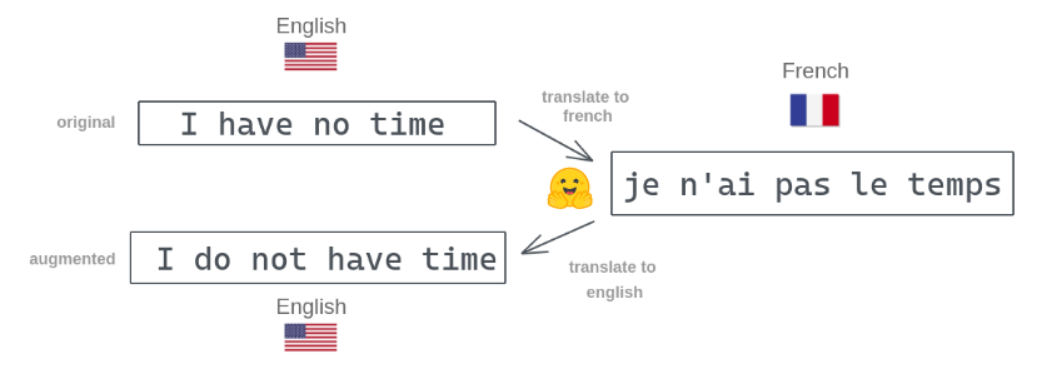

In [ ]:
run_data_augmentation = True #@param {type:"boolean"}

if run_data_augmentation:
    # Get the name of the first model
    first_model_name = 'Helsinki-NLP/opus-mt-en-fr'
    # Get the name of the second model
    second_model_name = 'Helsinki-NLP/opus-mt-fr-en'

    # Get the tokenizer
    first_model_tkn = AutoTokenizer.from_pretrained(first_model_name)
    # Get the tokenizer
    second_model_tkn = AutoTokenizer.from_pretrained(second_model_name)

    # Load the pretrained model based on the name
    first_model = MarianMTModel.from_pretrained(first_model_name)
    # Load the pretrained model based on the name
    second_model = MarianMTModel.from_pretrained(second_model_name)
    clear_output()

    df_train_aumentation = perform_data_augmentation(df_train_aumentation, first_model, second_model, first_model_tkn, second_model_tkn, batch_size=64, columns=['Premise', 'Conclusion'], device=device)
    clear_output()
    torch.cuda.empty_cache()

    df_train_aumentation_original = df_train_aumentation[[*['Argument ID', 'Conclusion', 'Stance', 'Premise'], *labels_columns]]
    df_train_aumentation_augmented = df_train_aumentation[[*['Argument ID', 'Conclusion BT', 'Stance', 'Premise BT'], *labels_columns]]
    df_train_aumentation_augmented.columns = [*['Argument ID', 'Conclusion', 'Stance', 'Premise'], *labels_columns]

    df_train_augmented = df_train_original.append(df_train_aumentation_augmented, ignore_index=True)

    # print(df_train_original.shape)
    # print(df_train_aumentation.shape)
    # print(df_train_augemnted.shape)

    og = df_train_original[labels_columns].sum()
    aug = df_train_augmented[labels_columns].sum()

    conc_sums = pd.concat([og, aug], axis=1)
    conc_sums.columns = ['original', 'augmented']
    conc_sums['percentage augmentation'] = (conc_sums['augmented'] / conc_sums['original']) - 1

<ipython-input-15-f1f2aa777648>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_augmented = df_train_original.append(df_train_aumentation_augmented, ignore_index=True)


We present the class distribution before and after data augmentation. The table shows that the data augmentation process has resulted in a reduction in class imbalance. Specifically, labels with lower support, such as label `Face`, have been augmented to a higher degree ($46\%$), while labels with higher support, such as `Achievement`, have been augmented to a lesser extent ($18\%$). This approach has helped to address the issue of class imbalance in the dataset by increasing the representation of minority classes while maintaining the distribution of majority classes.

In [ ]:
conc_sums

,original,augmented,percentage augmentation
Self-direction: thought,988,1169,0.183198
Self-direction: action,1395,1712,0.227240
Stimulation,247,361,0.461538
Hedonism,172,270,0.569767
Achievement,1512,1791,0.184524
Power: dominance,610,877,0.437705
Power: resources,625,949,0.518400
Face,382,560,0.465969
Security: personal,2000,2389,0.194500
Security: societal,1728,1974,0.142361


In [ ]:
print(df_train_original.shape)
print(df_train_aumentation.shape)
print(df_train_augmented.shape)

(5393, 24)
(1602, 26)
(6995, 24)


# Model Definition

In this section, a `BERT` pretrained model is implemented in order to classify multiple labels of a text. In such cases, the pre-trained model serves as a feature extractor, with the goal of extracting meaningful and informative features from the input text to be used in the downstream task.

One of the ways that BERT models do this is by using a special token called the $[CLS]$ token, which stands for "classification". When fine-tuning `BERT` for the human value detection task, the $[CLS]$ token is used as the final hidden state of the model, which is then passed through a linear layer to perform the classification. The $[CLS]$ token of the BERT model is passed through a `Tanh activation` function in order to limit the range of the output values. This helps to reduce the variance of the values and make them more manageable for downstream tasks like classification. The Tanh function also helps to normalize the output values, allowing for more consistent predictions.

By applying a linear layer after the $[CLS]$ token, the model can learn to map the features extracted by the pre-trained BERT model to the specific classification task at hand. The output of the linear layer is a vector of scores, one for each possible class in the classification task, which can be transformed into probabilities using a `sigmoid` function to make the final prediction over each label.

The loss function used is `BCEWithLogitsLoss` implemented in PyTorch. This loss combines a Sigmoid layer and the BCELoss in one single class


## bert-base-uncased

In [ ]:
model_name = 'bert-base-uncased'
num_labels = len(labels_columns)

N_EPOCHS = 6
N_EPOCHS_TL = 10

batch_size = 16

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [ ]:
train_df = get_processed_df(df_train_original, labels_columns, tokenizer.sep_token)
test_df = get_processed_df(df_test_original, labels_columns, tokenizer.sep_token)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'train shape: {train_df.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (4314, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [ ]:
train_df_aug = get_processed_df(df_train_aumentation_augmented, labels_columns, tokenizer.sep_token)
train_df_aug = pd.concat([train_df, train_df_aug], ignore_index=True)

print(f'train shape: {train_df_aug.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (5916, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [ ]:
steps_per_epoch=len(train_df) // batch_size
steps_per_epoch_aug=len(train_df_aug) // batch_size

total_training_steps = steps_per_epoch * N_EPOCHS
total_training_steps_aug = steps_per_epoch_aug * N_EPOCHS
total_training_steps_tl = steps_per_epoch * N_EPOCHS_TL

warmup_steps = total_training_steps // N_EPOCHS
warmup_steps_aug = total_training_steps_aug // N_EPOCHS
warmup_steps_tl = total_training_steps_tl // N_EPOCHS_TL

print('not augmented scheduled steps', (warmup_steps, total_training_steps))
print('augmented scheduled steps', (warmup_steps_aug, total_training_steps_aug))
print('transfer-learning scheduled steps', (warmup_steps_tl, total_training_steps_tl))

not augmented scheduled steps (269, 1614)
augmented scheduled steps (369, 2214)
transfer-learning scheduled steps (269, 2690)


**HumanValuesDataModule Class**

The CustomDataset class is a custom implementation of the PyTorch-lighting `pl.LightningDataModule` class. It is designed to accept a tokenizer, the train, evaluation and test dataframes, and a max_length parameter as inputs.

The class takes the text data of the input dataframe and tokenizes it using the `tokenizer`. The tokenizer generates the necessary inputs for the BERT model, including the input IDs, attention mask, and token type IDs.

The target values are the categories labeled as $0$ or $1$ in the dataframe.

The `HumanValuesDataModule` class is used to contains three datasets: one for training, one for validation and one for testing. The training Dataset is used to fine-tune the model, while the validation Dataset is used to evaluate the performance of the model during train. The test Dataset is used to test the model once the training is completed. By creating separate datasets for training and validation, we can ensure that the model does not overfit to the training data and generalizes well to new data.





In [ ]:
data_module = HumanValuesDataModule(train_df, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module.setup()

data_module_aug = HumanValuesDataModule(train_df_aug, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module_aug.setup()

### Hyperparameters Tuning

To optimize the hyperparameters of our `TransformerClassifier` model, we used the HyperparameterTuner class, that uses optuna framework to find the best hyperparameters. 

We first defined a partial function of the `TransformerClassifier`, with some of the hyperparameters already set, such as the `model_name`, `num_labels`, and the number of training and warm-up steps.

Next, we defined a dictionary `study_params` with the hyperparameters we wanted to tune. These included:
- the number of epochs
- the number of trials
- the learning rate for the transformer layers
- the learning rate for the classifier layers
- the weight decay for regularization
- the dropout rate for the classifier layer.

The percentage of training and validation batches to use are set respectively to 20% and 40%.

The tuner's `run_study()` method, executes the hyperparameter search within the search space.

The `HyperparameterTuner` performed a Bayesian optimization search over the hyperparameter space, trying different combinations of hyperparameters to find the optimal set. After the search was complete, the tuner returned the best set of hyperparameters, which we used to train our final model.

By using the `HyperparameterTuner`, we were able to efficiently search the hyperparameter space and find the best combination of hyperparameters for our `TransformerClassifier` model, resulting in improved performance and accuracy.

In [ ]:
tune = False
if tune:
    partial_model = partial(TransformerClassifier, model_name, num_labels, n_training_steps=total_training_steps, n_warmup_steps=warmup_steps)

    study_params = {
        "n_epochs": 3,
        "n_trials": 16,
        "lim_train_batches": 0.2,
        "lim_val_batches": 0.4,
        "lr_transformer": [2e-5, 5e-5],
        "lr_classifier": [1e-4, 1e-3],
        "weight_decay": [1e-5, 1e-4],
        "classifier_dropout": [.1, .3],
    }
    
    tuner = HyperparameterTuner(data_module, partial_model, study_params)
    tuner.run_study()
    tuned_hyperparameters = tuner.get_best_hyperparams()

In [ ]:
tuned_hyperparameters

{'lr_transformer': 5e-05,
 'lr_classifier': 0.001,
 'weight_decay': 1e-05,
 'classifier_dropout': 0.1}

In [ ]:
transformer_classifier = TransformerClassifier(model_name, 
                                               num_labels, 
                                               classifier_dropout=0.1, 
                                               optimizer=torch.optim.AdamW, 
                                               lr_transformer=5e-05, 
                                               lr_classifier=1e-3,
                                               weight_decay=1e-5,
                                               n_training_steps=total_training_steps, 
                                               n_warmup_steps=warmup_steps,
                                               )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
transformer_classifier_aug = TransformerClassifier(model_name, 
                                                   num_labels, 
                                                   classifier_dropout=0.1, 
                                                   optimizer=torch.optim.AdamW, 
                                                   lr_transformer=5e-05, 
                                                   lr_classifier=1e-3,
                                                   weight_decay=1e-5,
                                                   n_training_steps=total_training_steps_aug, 
                                                   n_warmup_steps=warmup_steps_aug,
                                                   )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
transformer_classifier_tl = TransformerClassifier(model_name, 
                                               num_labels, 
                                               classifier_dropout=0.1, 
                                               optimizer=torch.optim.AdamW, 
                                               transfer_learning=True,
                                               lr_transformer=5e-05, 
                                               lr_classifier=1e-3,
                                               weight_decay=1e-5,
                                               n_training_steps=total_training_steps_tl, 
                                               n_warmup_steps=warmup_steps_tl,
                                               )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
torch.cuda.empty_cache()

### Training

Here we define a training function that trains the model on the training dataset created above, specifying the number of epochs.

Following events happen in this function to fine tune the neural network:

The dataloader passes data to the model based on the batch size.
Subsequent output from the model and the actual category are compared to calculate the loss.
Loss value is used to optimize the weights of the neurons in the network.

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/baseline

clear_output()

In [ ]:
# e9ec24521d2c9a845865b5e4d6be07386c8843aa
wandb.login(key='e9ec24521d2c9a845865b5e4d6be07386c8843aa')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")
try:
    wandb.finish()
except:
    pass
clear_output()
wandb_logger = WandbLogger(project="human-value-final", name='baseline-bert-base')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu'
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(transformer_classifier, log="all")

trainer.fit(transformer_classifier, data_module)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/human-value-detection/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.990   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 270: 'val_loss' reached 0.35711 (best 0.35711), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 540: 'val_loss' reached 0.32361 (best 0.32361), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 810: 'val_loss' reached 0.31830 (best 0.31830), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1080: 'val_loss' was not in top 1


In [ ]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint-v3.ckpt' '/content/drive/MyDrive/human-value-detection/models/baseline-bert-base.ckpt'

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")
try:
    wandb.finish()
except:
    pass
clear_output()
wandb_logger = WandbLogger(project="human-value-final", name='baseline-bert-base-aug')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu'
)

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆████████
lr-AdamW/pg1,▁▃▅▆███▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
lr-AdamW/pg2,▁▃▅▆███▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
train_loss,███▇▆▆▇▆▇▆▅▄▆▄▄▃▅▄▄▃▄▄▃▂▂▁▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▆▇█
val_f1,▁▅▇█
val_loss,█▂▁▂
epoch,3
lr-AdamW/pg1,1e-05
lr-AdamW/pg2,0.00012


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(transformer_classifier_aug, log="all")

trainer.fit(transformer_classifier_aug, data_module_aug)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/human-value-detection/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.990   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 370: 'val_loss' reached 0.34104 (best 0.34104), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 740: 'val_loss' reached 0.30777 (best 0.30777), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1110: 'val_loss' reached 0.29041 (best 0.29041), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1480: 'val_loss' was not in top 1


In [ ]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' '/content/drive/MyDrive/human-value-detection/models/baseline-bert-base-aug.ckpt'

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")
try:
    wandb.finish()
except:
    pass
wandb_logger = WandbLogger(project="human-value-final", name='baseline-bert-base-tl')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS_TL,
  accelerator='gpu'
)

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆████████
lr-AdamW/pg1,▁▂▃▄▅▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃
lr-AdamW/pg2,▁▂▃▄▅▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃
train_loss,██▇▆▇▅▆▆▆▄▆▅▄▄▃▃▅▂▃▂▃▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▄▇█
val_f1,▁▅▇█
val_loss,█▃▁▃
epoch,3
lr-AdamW/pg1,2e-05
lr-AdamW/pg2,0.00041


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(transformer_classifier_tl, log="all")

trainer.fit(transformer_classifier_tl, data_module)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/human-value-detection/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
15.4 K    Trainable params
109 M     Non-trainable params
109 M     Total params
437.990   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 270: 'val_loss' reached 0.41527 (best 0.41527), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 540: 'val_loss' reached 0.40844 (best 0.40844), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 810: 'val_loss' reached 0.40699 (best 0.40699), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1080: 'val_loss' reached 0.40009 (best 0.40009), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1350: 'val_loss' reached 0.39788 (best 0.39788), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1620: 'val_loss' reached 0.39559 (best 0.39559), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' '/content/drive/MyDrive/human-value-detection/models/baseline-bert-base-tl.ckpt'

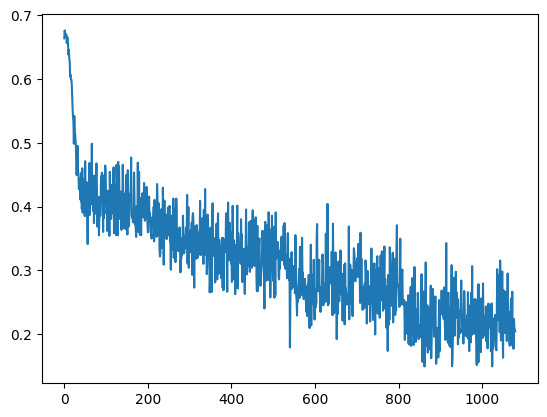

In [ ]:
plt.plot([i.cpu().item() for i in transformer_classifier.losses])

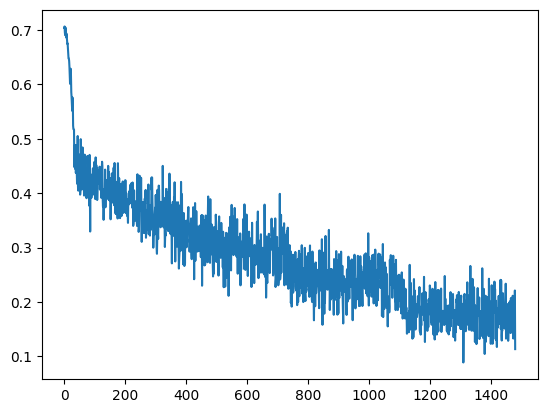

In [ ]:
plt.plot([i.cpu().item() for i in transformer_classifier_aug.losses])

### Predictions

In [ ]:
baseline = TransformerClassifier.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/baseline-bert-base.ckpt",
  **{'model_name':model_name, 'num_labels':num_labels, 'classifier_dropout':.1, 'optimizer':torch.optim.AdamW},
)
baseline_aug = TransformerClassifier.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/baseline-bert-base-aug.ckpt",
  **{'model_name':model_name, 'num_labels':num_labels, 'classifier_dropout':.1, 'optimizer':torch.optim.AdamW},
)
baseline_tl = TransformerClassifier.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/baseline-bert-base-tl.ckpt",
  **{'model_name':model_name, 'num_labels':num_labels, 'classifier_dropout':.1, 'optimizer':torch.optim.AdamW, 'transfer_learning':True},
)

In [ ]:
baseline.eval()
baseline.freeze()

baseline_aug.eval()
baseline_aug.freeze()

baseline_tl.eval()
baseline_tl.freeze()

In [ ]:
baseline_predictions_train = trainer.predict(baseline, data_module.threshold_train_dataloader())
baseline_aug_predictions_train = trainer.predict(baseline_aug, data_module.threshold_train_dataloader())
baseline_tl_predictions_train = trainer.predict(baseline_tl, data_module.threshold_train_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
baseline_pred_labels_train = np.array([pred.cpu().numpy() for preds in baseline_predictions_train for pred in preds])
baseline_aug_pred_labels_train = np.array([pred.cpu().numpy() for preds in baseline_aug_predictions_train for pred in preds])
baseline_tl_pred_labels_train = np.array([pred.cpu().numpy() for preds in baseline_tl_predictions_train for pred in preds])
true_labels_train = np.array([i for i in train_df['labels']])

In [ ]:
baseline_predictions_test = trainer.predict(baseline, data_module.test_dataloader())
baseline_aug_predictions_test = trainer.predict(baseline_aug, data_module.test_dataloader())
baseline_tl_predictions_test = trainer.predict(baseline_tl, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
with open('baseline_tl_predictions_test.npy', 'wb') as f:
    np.save(f, baseline_tl_predictions_test)

In [ ]:
baseline_pred_labels_test = np.array([pred.cpu().numpy() for preds in baseline_predictions_test for pred in preds])
baseline_aug_pred_labels_test = np.array([pred.cpu().numpy() for preds in baseline_aug_predictions_test for pred in preds])
baseline_tl_pred_labels_test = np.array([pred.cpu().numpy() for preds in baseline_tl_predictions_test for pred in preds])

true_labels_test = np.array([i for i in test_df['labels']])

#### Threshold Optimization

At inference time, confidence scores are outputted by a probabilistic classifier, and thresholds are applied to decide which classes are detected as active. In this section 3 different methods are presented:

- **Manual Threshold**: The manual threshold method involves setting the threshold beforehand, without any optimization for the specific task at hand. In this case, the threshold is set to a static value of 0.5, meaning that any output probability score greater than or equal to 0.5 is considered positive, while anything less than 0.5 is considered negative.


- **F1-score Optimized Threshold**: This method involves finding the best threshold to approximate each score to either 0 or 1 based on the highest F1 score. To accomplish this, for each label, all possible threshold values between 0.1 and 0.85, with a step size of 0.05, are considered. The threshold value that results in the highest F1 score is then chosen for that label as the optimized threshold for the given task. This method involves finding specific threshold for each label.


- **Surrogate Gradient Learning of Thresholds**: This method is proposed in the Paper [Fast Threshold Optimization for Multi-Label Audio Tagging Using Surrogate Gradient Learning](https://arxiv.org/pdf/2103.00833.pdf) The goal is to automatically optimize the decision thresholds using a performance metric, in this case, the Cross Entropy Loss. The proposed method utilizes *gradient descent* to optimize the decision thresholds. Since F1 is not differentiable, the thresholding operation gradients are approximated with the gradients of a sigmoid function. The confidence scores are calculated by the `TransformerClassifier`, and the sigmoid of that confidence scores are then used to update the decision thresholds via gradient descent.



In [ ]:
MANUAL_THRESHOLD = .5

In [ ]:
f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, baseline_pred_labels_train, labels_columns)
print(f'optimized_thresholds BASELINE: \n{f1_score_optimized_thresholds}')

f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns)
print(f'optimized_thresholds BASELINE AUGMENTATION: \n{f1_score_optimized_thresholds}')

f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, baseline_tl_pred_labels_train, labels_columns)
print(f'optimized_thresholds BASELINE TRANSFER LEARNING: \n{f1_score_optimized_thresholds}')

optimized_thresholds BASELINE: 
[0.5, 0.4, 0.25, 0.55, 0.45, 0.2, 0.4, 0.2, 0.4, 0.25, 0.4, 0.25, 0.2, 0.2, 0.25, 0.25, 0.25, 0.45, 0.3, 0.3]
optimized_thresholds BASELINE AUGMENTATION: 
[0.35, 0.3, 0.35, 0.3, 0.4, 0.3, 0.45, 0.25, 0.5, 0.4, 0.35, 0.4, 0.2, 0.3, 0.4, 0.2, 0.35, 0.45, 0.35, 0.25]
optimized_thresholds BASELINE TRANSFER LEARNING: 
[0.2, 0.25, 0.05, 0.0, 0.25, 0.1, 0.15, 0.05, 0.35, 0.3, 0.15, 0.2, 0.05, 0.1, 0.2, 0.15, 0.4, 0.1, 0.15, 0.2]


--------------------
learned_thresholds BASELINE: 
[0.36772132 0.29865107 0.26422942 0.42595983 0.33086875 0.19114141
 0.32805517 0.24847429 0.27359796 0.15000147 0.27379113 0.18149574
 0.21421786 0.1775404  0.22971013 0.2323497  0.16353302 0.29042205
 0.26381025 0.27864352]
--------------------
learned_thresholds BASELINE AUG: 
[0.2410007  0.20589867 0.31507114 0.2616106  0.29433352 0.24242266
 0.38049257 0.22938655 0.38034004 0.25604546 0.29724616 0.25786406
 0.20130843 0.26502305 0.29579982 0.16908246 0.25959978 0.36431536
 0.2611859  0.20788302]


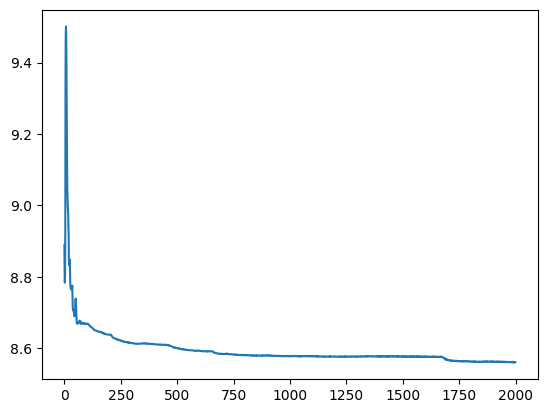

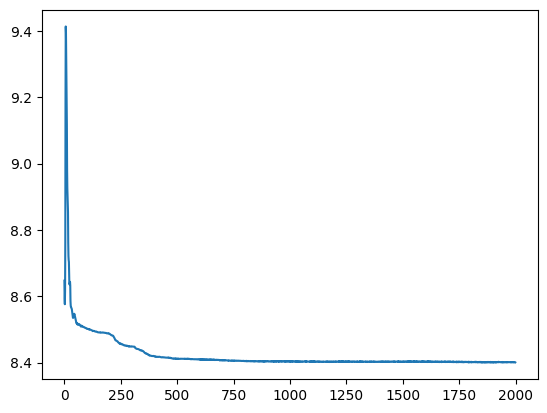

In [ ]:
# BASELINE

threshold_fn = SurrogateHeaviside.apply
model = ThresholdModel(threshold_fn=threshold_fn, device=device, t=.5, sigma=1., num_labels=num_labels, use_dense=False)
criterion = torch.nn.CrossEntropyLoss()

train_thresholding_model(model=model, 
                         predictions=baseline_pred_labels_train,
                         labels=true_labels_train,
                         epochs=2000, 
                         criterion=criterion, 
                         num_labels=num_labels,
                         lr=1e-01,
                         verbose=False
                         )
learned_thresholds=model.thresh.clone().detach().cpu().numpy()
sigma = model.sigma.clone().detach().cpu().numpy()
print(f'learned_thresholds BASELINE: \n{learned_thresholds}')

# BASELINE AUGMENTATION
threshold_fn = SurrogateHeaviside.apply
model = ThresholdModel(threshold_fn=threshold_fn, device=device, t=.5, sigma=1., num_labels=num_labels, use_dense=False)
criterion = torch.nn.CrossEntropyLoss()

train_thresholding_model(model=model, 
                         predictions=baseline_aug_pred_labels_train,
                         labels=true_labels_train,
                         epochs=2000, 
                         criterion=criterion, 
                         num_labels=num_labels,
                         lr=1e-01,
                         verbose=False
                         )
learned_thresholds=model.thresh.clone().detach().cpu().numpy()
sigma = model.sigma.clone().detach().cpu().numpy()
print(f'learned_thresholds BASELINE AUG: \n{learned_thresholds}')

#### Train

In [ ]:
print_classification_report_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.88      0.75      0.81       804
    Self-direction: action       0.93      0.66      0.78      1134
               Stimulation       0.71      0.37      0.48       196
                  Hedonism       0.86      0.55      0.68       137
               Achievement       0.89      0.81      0.85      1212
          Power: dominance       0.87      0.42      0.57       482
          Power: resources       0.83      0.90      0.86       496
                      Face       0.81      0.17      0.28       304
        Security: personal       0.89      0.90      0.90      1594
        Security: societal       0.92      0.81      0.86      1383
                 Tradition       0.94      0.81      0.87       454
         Conformity: rules       0.87      0.67      0.76       928
 Conformity: interpersonal       0.90      0.48      0.63       172
                  Humility       0.83      0.57

In [ ]:
print_classification_report_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.72      0.90      0.80       804
    Self-direction: action       0.81      0.85      0.83      1134
               Stimulation       0.18      0.88      0.30       196
                  Hedonism       0.03      1.00      0.06       137
               Achievement       0.74      0.93      0.83      1212
          Power: dominance       0.35      0.86      0.50       482
          Power: resources       0.57      0.98      0.72       496
                      Face       0.18      0.95      0.31       304
        Security: personal       0.80      0.94      0.86      1594
        Security: societal       0.84      0.91      0.87      1383
                 Tradition       0.74      0.93      0.82       454
         Conformity: rules       0.61      0.89      0.72       928
 Conformity: interpersonal       0.34      0.94      0.50       172
                  Humility       0.38      0.89

In [ ]:
print_classification_report_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns, threshold=learned_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.75      0.88      0.81       804
    Self-direction: action       0.76      0.88      0.82      1134
               Stimulation       0.56      0.58      0.57       196
                  Hedonism       0.74      0.77      0.75       137
               Achievement       0.78      0.92      0.84      1212
          Power: dominance       0.63      0.66      0.64       482
          Power: resources       0.77      0.94      0.85       496
                      Face       0.58      0.59      0.58       304
        Security: personal       0.82      0.93      0.87      1594
        Security: societal       0.80      0.93      0.86      1383
                 Tradition       0.89      0.88      0.88       454
         Conformity: rules       0.66      0.86      0.75       928
 Conformity: interpersonal       0.68      0.74      0.71       172
                  Humility       0.69      0.79

#### Test BASELINE


In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_pred_labels_test, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.53      0.49      0.51       251
    Self-direction: action       0.67      0.47      0.55       496
               Stimulation       0.63      0.09      0.15       138
                  Hedonism       0.58      0.21      0.31       103
               Achievement       0.69      0.59      0.64       575
          Power: dominance       0.65      0.08      0.14       164
          Power: resources       0.44      0.49      0.46       132
                      Face       0.00      0.00      0.00       130
        Security: personal       0.74      0.75      0.75       759
        Security: societal       0.79      0.41      0.54       488
                 Tradition       0.55      0.33      0.41       172
         Conformity: rules       0.67      0.24      0.36       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       1.00      0.01

In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.34      0.75      0.46       251
    Self-direction: action       0.47      0.71      0.56       496
               Stimulation       0.15      0.67      0.24       138
                  Hedonism       0.05      1.00      0.10       103
               Achievement       0.55      0.77      0.64       575
          Power: dominance       0.23      0.54      0.32       164
          Power: resources       0.35      0.86      0.50       132
                      Face       0.10      0.77      0.18       130
        Security: personal       0.67      0.83      0.74       759
        Security: societal       0.70      0.55      0.62       488
                 Tradition       0.34      0.50      0.40       172
         Conformity: rules       0.51      0.61      0.55       455
 Conformity: interpersonal       0.10      0.47      0.16        60
                  Humility       0.13      0.17

In [ ]:
baseline_report = print_classification_report_thresholding(true_labels_test, baseline_pred_labels_test, labels_columns, threshold=learned_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.35      0.70      0.47       251
    Self-direction: action       0.42      0.75      0.54       496
               Stimulation       0.33      0.12      0.17       138
                  Hedonism       0.37      0.36      0.36       103
               Achievement       0.59      0.74      0.66       575
          Power: dominance       0.35      0.23      0.27       164
          Power: resources       0.43      0.61      0.50       132
                      Face       0.27      0.16      0.20       130
        Security: personal       0.68      0.82      0.75       759
        Security: societal       0.66      0.58      0.62       488
                 Tradition       0.43      0.43      0.43       172
         Conformity: rules       0.54      0.51      0.52       455
 Conformity: interpersonal       0.29      0.15      0.20        60
                  Humility       0.20      0.03

#### Test BASELINE AUG


In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_aug_pred_labels_test, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.66      0.42      0.51       251
    Self-direction: action       0.64      0.38      0.48       496
               Stimulation       0.57      0.09      0.16       138
                  Hedonism       0.67      0.16      0.25       103
               Achievement       0.71      0.60      0.65       575
          Power: dominance       0.68      0.09      0.16       164
          Power: resources       0.43      0.52      0.47       132
                      Face       0.50      0.01      0.02       130
        Security: personal       0.70      0.80      0.75       759
        Security: societal       0.70      0.52      0.60       488
                 Tradition       0.63      0.32      0.42       172
         Conformity: rules       0.58      0.40      0.48       455
 Conformity: interpersonal       0.67      0.10      0.17        60
                  Humility       0.24      0.04

In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_aug_pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.44      0.57      0.50       251
    Self-direction: action       0.52      0.54      0.53       496
               Stimulation       0.20      0.52      0.29       138
                  Hedonism       0.05      1.00      0.10       103
               Achievement       0.58      0.74      0.65       575
          Power: dominance       0.20      0.48      0.28       164
          Power: resources       0.34      0.83      0.48       132
                      Face       0.13      0.67      0.22       130
        Security: personal       0.64      0.88      0.74       759
        Security: societal       0.60      0.65      0.63       488
                 Tradition       0.41      0.43      0.42       172
         Conformity: rules       0.46      0.65      0.54       455
 Conformity: interpersonal       0.10      0.47      0.17        60
                  Humility       0.15      0.35

In [ ]:
baseline_aug_report = print_classification_report_thresholding(true_labels_test, baseline_aug_pred_labels_test, labels_columns, threshold=learned_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.49      0.54      0.51       251
    Self-direction: action       0.49      0.60      0.54       496
               Stimulation       0.40      0.12      0.19       138
                  Hedonism       0.58      0.28      0.38       103
               Achievement       0.61      0.70      0.65       575
          Power: dominance       0.33      0.21      0.26       164
          Power: resources       0.40      0.61      0.48       132
                      Face       0.28      0.15      0.19       130
        Security: personal       0.66      0.87      0.75       759
        Security: societal       0.57      0.68      0.62       488
                 Tradition       0.53      0.40      0.46       172
         Conformity: rules       0.49      0.60      0.54       455
 Conformity: interpersonal       0.32      0.28      0.30        60
                  Humility       0.12      0.09

#### Test BASELINE TRANSFER LEARNING


In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_tl_pred_labels_test, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.00      0.00      0.00       251
    Self-direction: action       0.00      0.00      0.00       496
               Stimulation       0.00      0.00      0.00       138
                  Hedonism       0.00      0.00      0.00       103
               Achievement       1.00      0.00      0.01       575
          Power: dominance       0.00      0.00      0.00       164
          Power: resources       0.00      0.00      0.00       132
                      Face       0.00      0.00      0.00       130
        Security: personal       0.74      0.21      0.33       759
        Security: societal       0.72      0.04      0.07       488
                 Tradition       0.00      0.00      0.00       172
         Conformity: rules       0.00      0.00      0.00       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       0.00      0.00

In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_tl_pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.30      0.43      0.36       251
    Self-direction: action       0.30      0.75      0.43       496
               Stimulation       0.17      0.28      0.21       138
                  Hedonism       0.05      1.00      0.10       103
               Achievement       0.39      0.89      0.55       575
          Power: dominance       0.11      0.77      0.20       164
          Power: resources       0.17      0.24      0.20       132
                      Face       0.07      1.00      0.13       130
        Security: personal       0.50      0.88      0.64       759
        Security: societal       0.40      0.66      0.50       488
                 Tradition       0.21      0.24      0.22       172
         Conformity: rules       0.27      0.85      0.41       455
 Conformity: interpersonal       0.01      0.02      0.01        60
                  Humility       0.13      0.14

In [ ]:
baseline_tl_report = print_classification_report_thresholding(true_labels_test, baseline_tl_pred_labels_test, labels_columns, threshold=learned_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.22      0.01      0.02       251
    Self-direction: action       0.26      0.94      0.41       496
               Stimulation       0.00      0.00      0.00       138
                  Hedonism       0.00      0.00      0.00       103
               Achievement       0.44      0.67      0.53       575
          Power: dominance       0.00      0.00      0.00       164
          Power: resources       0.00      0.00      0.00       132
                      Face       0.00      0.00      0.00       130
        Security: personal       0.55      0.79      0.65       759
        Security: societal       0.33      0.82      0.47       488
                 Tradition       0.00      0.00      0.00       172
         Conformity: rules       0.36      0.28      0.32       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       0.00      0.00

## all-mpnet-base-v2

In [ ]:
model_name = 'sentence-transformers/all-mpnet-base-v2'
num_labels = len(labels_columns)

N_EPOCHS = 6
N_EPOCHS_TL = 10

batch_size = 16

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [ ]:
train_df = get_processed_df(df_train_original, labels_columns, tokenizer.sep_token)
test_df = get_processed_df(df_test_original, labels_columns, tokenizer.sep_token)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'train shape: {train_df.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (4314, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [ ]:
train_df_aug = get_processed_df(df_train_aumentation_augmented, labels_columns, tokenizer.sep_token)
train_df_aug = pd.concat([train_df, train_df_aug], ignore_index=True)

print(f'train shape: {train_df_aug.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (5916, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [ ]:
steps_per_epoch=len(train_df) // batch_size
steps_per_epoch_aug=len(train_df_aug) // batch_size

total_training_steps = steps_per_epoch * N_EPOCHS
total_training_steps_aug = steps_per_epoch_aug * N_EPOCHS
total_training_steps_tl = steps_per_epoch * N_EPOCHS_TL

warmup_steps = total_training_steps // N_EPOCHS
warmup_steps_aug = total_training_steps_aug // N_EPOCHS
warmup_steps_tl = total_training_steps_tl // N_EPOCHS_TL

print('not augmented scheduled steps', (warmup_steps, total_training_steps))
print('augmented scheduled steps', (warmup_steps_aug, total_training_steps_aug))
print('transfer-learning scheduled steps', (warmup_steps_tl, total_training_steps_tl))

not augmented scheduled steps (269, 1614)
augmented scheduled steps (369, 2214)
transfer-learning scheduled steps (269, 2690)


**HumanValuesDataModule Class**

The CustomDataset class is a custom implementation of the PyTorch-lighting `pl.LightningDataModule` class. It is designed to accept a tokenizer, the train, evaluation and test dataframes, and a max_length parameter as inputs.

The class takes the text data of the input dataframe and tokenizes it using the `tokenizer`. The tokenizer generates the necessary inputs for the BERT model, including the input IDs, attention mask, and token type IDs.

The target values are the categories labeled as $0$ or $1$ in the dataframe.

The `HumanValuesDataModule` class is used to contains three datasets: one for training, one for validation and one for testing. The training Dataset is used to fine-tune the model, while the validation Dataset is used to evaluate the performance of the model during train. The test Dataset is used to test the model once the training is completed. By creating separate datasets for training and validation, we can ensure that the model does not overfit to the training data and generalizes well to new data.





In [ ]:
data_module = HumanValuesDataModule(train_df, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module.setup()

data_module_aug = HumanValuesDataModule(train_df_aug, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module_aug.setup()

### Hyperparameters Tuning

To optimize the hyperparameters of our `TransformerClassifier` model, we used the HyperparameterTuner class, that uses optuna framework to find the best hyperparameters. 

We first defined a partial function of the `TransformerClassifier`, with some of the hyperparameters already set, such as the `model_name`, `num_labels`, and the number of training and warm-up steps.

Next, we defined a dictionary `study_params` with the hyperparameters we wanted to tune. These included:
- the number of epochs
- the number of trials
- the learning rate for the transformer layers
- the learning rate for the classifier layers
- the weight decay for regularization
- the dropout rate for the classifier layer.

The percentage of training and validation batches to use are set respectively to 20% and 40%.

The tuner's `run_study()` method, executes the hyperparameter search within the search space.

The `HyperparameterTuner` performed a Bayesian optimization search over the hyperparameter space, trying different combinations of hyperparameters to find the optimal set. After the search was complete, the tuner returned the best set of hyperparameters, which we used to train our final model.

By using the `HyperparameterTuner`, we were able to efficiently search the hyperparameter space and find the best combination of hyperparameters for our `TransformerClassifier` model, resulting in improved performance and accuracy.

In [ ]:
tune = False
if tune:
    partial_model = partial(TransformerClassifier, model_name, num_labels, n_training_steps=total_training_steps, n_warmup_steps=warmup_steps)

    study_params = {
        "n_epochs": 3,
        "n_trials": 16,
        "lim_train_batches": 0.2,
        "lim_val_batches": 0.4,
        "lr_transformer": [2e-5, 5e-5],
        "lr_classifier": [1e-4, 1e-3],
        "weight_decay": [1e-5, 1e-4],
        "classifier_dropout": [.1, .3],
    }
    
    tuner = HyperparameterTuner(data_module, partial_model, study_params)
    tuner.run_study()
    tuned_hyperparameters = tuner.get_best_hyperparams()

In [ ]:
tuned_hyperparameters

{'lr_transformer': 5e-05,
 'lr_classifier': 0.001,
 'weight_decay': 1e-05,
 'classifier_dropout': 0.1}

In [ ]:
transformer_classifier = TransformerClassifier(model_name, 
                                               num_labels, 
                                               classifier_dropout=0.1, 
                                               optimizer=torch.optim.AdamW, 
                                               lr_transformer=5e-05, 
                                               lr_classifier=1e-3,
                                               weight_decay=1e-5,
                                               n_training_steps=total_training_steps, 
                                               n_warmup_steps=warmup_steps,
                                               )

In [ ]:
transformer_classifier_aug = TransformerClassifier(model_name, 
                                                   num_labels, 
                                                   classifier_dropout=0.1, 
                                                   optimizer=torch.optim.AdamW, 
                                                   lr_transformer=5e-05, 
                                                   lr_classifier=1e-3,
                                                   weight_decay=1e-5,
                                                   n_training_steps=total_training_steps_aug, 
                                                   n_warmup_steps=warmup_steps_aug,
                                                   )

In [ ]:
transformer_classifier_tl = TransformerClassifier(model_name, 
                                               num_labels, 
                                               classifier_dropout=0.1, 
                                               optimizer=torch.optim.AdamW, 
                                               transfer_learning=True,
                                               lr_transformer=5e-05, 
                                               lr_classifier=1e-3,
                                               weight_decay=1e-5,
                                               n_training_steps=total_training_steps_tl, 
                                               n_warmup_steps=warmup_steps_tl,
                                               )

In [ ]:
torch.cuda.empty_cache()

### Training

Here we define a training function that trains the model on the training dataset created above, specifying the number of epochs.

Following events happen in this function to fine tune the neural network:

The dataloader passes data to the model based on the batch size.
Subsequent output from the model and the actual category are compared to calculate the loss.
Loss value is used to optimize the weights of the neurons in the network.

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/baseline

clear_output()

In [ ]:
# e9ec24521d2c9a845865b5e4d6be07386c8843aa
wandb.login(key='e9ec24521d2c9a845865b5e4d6be07386c8843aa')

wandb: Currently logged in as: nlp-project-unibo (human-value-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")
try:
    wandb.finish()
except:
    pass
clear_output()
wandb_logger = WandbLogger(project="human-value-final", name='baseline-mpnet-base')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu'
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(transformer_classifier, log="all")

trainer.fit(transformer_classifier, data_module)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | MPNetModel        | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.007   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 270: 'val_loss' reached 0.38010 (best 0.38010), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 540: 'val_loss' reached 0.33820 (best 0.33820), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 810: 'val_loss' reached 0.31273 (best 0.31273), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1080: 'val_loss' reached 0.30752 (best 0.30752), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1350: 'val_loss' was not in top 1


In [ ]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' '/content/drive/MyDrive/human-value-detection/models/baseline-mpnet-base.ckpt'

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")
try:
    wandb.finish()
except:
    pass
clear_output()
wandb_logger = WandbLogger(project="human-value-final", name='baseline-mpnet-base-aug')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu'
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(transformer_classifier_aug, log="all")

trainer.fit(transformer_classifier_aug, data_module_aug)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/human-value-detection/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | MPNetModel        | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.007   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 370: 'val_loss' reached 0.34924 (best 0.34924), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 740: 'val_loss' reached 0.30470 (best 0.30470), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1110: 'val_loss' reached 0.28975 (best 0.28975), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1480: 'val_loss' reached 0.28895 (best 0.28895), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1850: 'val_loss' was not in top 1


In [ ]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint-v1.ckpt' '/content/drive/MyDrive/human-value-detection/models/baseline-mpnet-base-aug.ckpt'

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
lr_monitor = LearningRateMonitor(logging_interval='step')

tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")
try:
    wandb.finish()
except:
    pass
wandb_logger = WandbLogger(project="human-value-final", name='baseline-mpnet-base-tl')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS_TL,
  accelerator='gpu'
)

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
lr-AdamW/pg1,▁▂▃▄▅▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂
lr-AdamW/pg2,▁▂▃▄▅▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂
train_loss,█▆▆▅▅▅▄▄▄▅▃▅▃▄▃▃▃▂▂▃▃▂▂▂▃▂▂▂▂▁▂▂▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_accuracy,▁▅▇██
val_f1,▁▄▆▇█
val_loss,█▃▁▁▂
epoch,4
lr-AdamW/pg1,1e-05
lr-AdamW/pg2,0.0002


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(transformer_classifier_tl, log="all")

trainer.fit(transformer_classifier_tl, data_module)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/human-value-detection/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | MPNetModel        | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
15.4 K    Trainable params
109 M     Non-trainable params
109 M     Total params
438.007   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 270: 'val_loss' reached 0.41787 (best 0.41787), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 540: 'val_loss' reached 0.39119 (best 0.39119), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 810: 'val_loss' reached 0.38051 (best 0.38051), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1080: 'val_loss' reached 0.37396 (best 0.37396), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1350: 'val_loss' reached 0.36975 (best 0.36975), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1620: 'val_loss' reached 0.36671 (best 0.36671), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1890: 'val_loss' reached 0.36438 (best 0.36438), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2160: 'val_loss' reached 0.36320 (best 0.36320), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2430: 'val_loss' reached 0.36234 (best 0.36234), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2700: 'val_loss' reached 0.36212 (best 0.36212), saving model to '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint-v2.ckpt' '/content/drive/MyDrive/human-value-detection/models/baseline-mpnet-base-tl.ckpt'

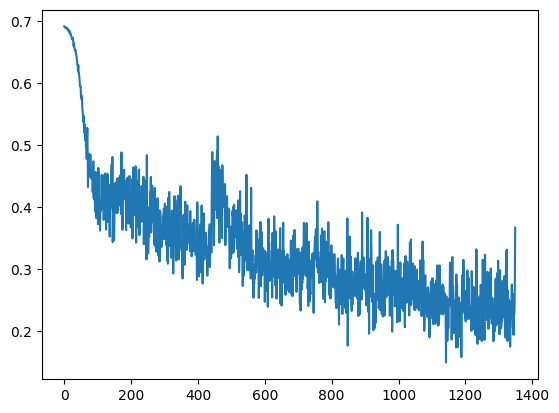

In [ ]:
plt.plot([i.cpu().item() for i in transformer_classifier.losses])

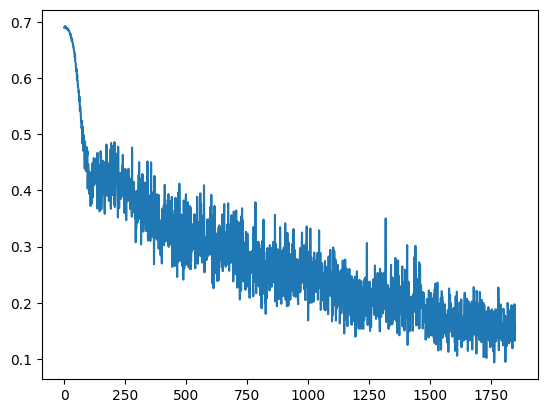

In [ ]:
plt.plot([i.cpu().item() for i in transformer_classifier_aug.losses])

### Predictions

In [ ]:
baseline = TransformerClassifier.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/baseline-mpnet-base.ckpt",
  **{'model_name':model_name, 'num_labels':num_labels, 'classifier_dropout':.1, 'optimizer':torch.optim.AdamW},
)
baseline_aug = TransformerClassifier.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/baseline-mpnet-base-aug.ckpt",
  **{'model_name':model_name, 'num_labels':num_labels, 'classifier_dropout':.1, 'optimizer':torch.optim.AdamW},
)
baseline_tl = TransformerClassifier.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/baseline-mpnet-base-tl.ckpt",
  **{'model_name':model_name, 'num_labels':num_labels, 'classifier_dropout':.1, 'optimizer':torch.optim.AdamW, 'transfer_learning':True},
)

In [ ]:
baseline.eval()
baseline.freeze()

baseline_aug.eval()
baseline_aug.freeze()

baseline_tl.eval()
baseline_tl.freeze()

In [ ]:
baseline_predictions_train = trainer.predict(baseline, data_module.threshold_train_dataloader())
baseline_aug_predictions_train = trainer.predict(baseline_aug, data_module.threshold_train_dataloader())
baseline_tl_predictions_train = trainer.predict(baseline_tl, data_module.threshold_train_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
baseline_pred_labels_train = np.array([pred.cpu().numpy() for preds in baseline_predictions_train for pred in preds])
baseline_aug_pred_labels_train = np.array([pred.cpu().numpy() for preds in baseline_aug_predictions_train for pred in preds])
baseline_tl_pred_labels_train = np.array([pred.cpu().numpy() for preds in baseline_tl_predictions_train for pred in preds])
true_labels_train = np.array([i for i in train_df['labels']])

In [ ]:
baseline_predictions_test = trainer.predict(baseline, data_module.test_dataloader())
baseline_aug_predictions_test = trainer.predict(baseline_aug, data_module.test_dataloader())
baseline_tl_predictions_test = trainer.predict(baseline_tl, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
baseline_pred_labels_test = np.array([pred.cpu().numpy() for preds in baseline_predictions_test for pred in preds])
baseline_aug_pred_labels_test = np.array([pred.cpu().numpy() for preds in baseline_aug_predictions_test for pred in preds])
baseline_tl_pred_labels_test = np.array([pred.cpu().numpy() for preds in baseline_tl_predictions_test for pred in preds])

true_labels_test = np.array([i for i in test_df['labels']])

In [ ]:
with open('mpnet_baseline_predictions_test.npy', 'wb') as f:
    np.save(f, baseline_pred_labels_test)

with open('mpnet_baseline_aug_predictions_test.npy', 'wb') as f:
    np.save(f, baseline_aug_pred_labels_test)

with open('mpnet_baseline_tl_predictions_test.npy', 'wb') as f:
    np.save(f, baseline_tl_pred_labels_test)

#### Threshold Optimization

At inference time, confidence scores are outputted by a probabilistic classifier, and thresholds are applied to decide which classes are detected as active. In this section 3 different methods are presented:

- **Manual Threshold**: The manual threshold method involves setting the threshold beforehand, without any optimization for the specific task at hand. In this case, the threshold is set to a static value of 0.5, meaning that any output probability score greater than or equal to 0.5 is considered positive, while anything less than 0.5 is considered negative.


- **F1-score Optimized Threshold**: This method involves finding the best threshold to approximate each score to either 0 or 1 based on the highest F1 score. To accomplish this, for each label, all possible threshold values between 0.1 and 0.85, with a step size of 0.05, are considered. The threshold value that results in the highest F1 score is then chosen for that label as the optimized threshold for the given task. This method involves finding specific threshold for each label.


- **Surrogate Gradient Learning of Thresholds**: This method is proposed in the Paper [Fast Threshold Optimization for Multi-Label Audio Tagging Using Surrogate Gradient Learning](https://arxiv.org/pdf/2103.00833.pdf) The goal is to automatically optimize the decision thresholds using a performance metric, in this case, the Cross Entropy Loss. The proposed method utilizes *gradient descent* to optimize the decision thresholds. Since F1 is not differentiable, the thresholding operation gradients are approximated with the gradients of a sigmoid function. The confidence scores are calculated by the `TransformerClassifier`, and the sigmoid of that confidence scores are then used to update the decision thresholds via gradient descent.



In [ ]:
MANUAL_THRESHOLD = .5

In [ ]:
f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, baseline_pred_labels_train, labels_columns)
print(f'optimized_thresholds BASELINE: \n{f1_score_optimized_thresholds}')

f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns)
print(f'optimized_thresholds BASELINE AUGMENTATION: \n{f1_score_optimized_thresholds}')

f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, baseline_tl_pred_labels_train, labels_columns)
print(f'optimized_thresholds BASELINE TRANSFER LEARNING: \n{f1_score_optimized_thresholds}')

optimized_thresholds BASELINE: 
[0.35, 0.25, 0.15, 0.2, 0.4, 0.25, 0.4, 0.2, 0.4, 0.45, 0.35, 0.4, 0.25, 0.25, 0.35, 0.2, 0.5, 0.35, 0.25, 0.3]
optimized_thresholds BASELINE AUGMENTATION: 
[0.45, 0.3, 0.2, 0.45, 0.4, 0.4, 0.35, 0.25, 0.45, 0.45, 0.3, 0.3, 0.45, 0.3, 0.3, 0.25, 0.45, 0.3, 0.3, 0.2]
optimized_thresholds BASELINE TRANSFER LEARNING: 
[0.2, 0.2, 0.05, 0.05, 0.3, 0.15, 0.15, 0.1, 0.35, 0.35, 0.15, 0.2, 0.1, 0.1, 0.2, 0.15, 0.35, 0.15, 0.15, 0.15]


--------------------
learned_thresholds BASELINE: 
[0.23358774 0.18309066 2.599056   2.334438   0.24376927 0.23045148
 0.26263133 0.23201442 0.29654974 0.2940246  0.24831192 0.2956785
 1.8749293  0.25664246 0.27938303 0.20702958 0.31648552 0.30833864
 0.2513436  0.22691442]
--------------------
learned_thresholds BASELINE AUG: 
[0.27631402 0.21055411 0.2426236  0.37576517 0.3137     0.285576
 0.2951592  0.24093607 0.24926008 0.30939534 0.2346044  0.19251029
 0.3292417  0.22419508 0.24843897 0.21908124 0.33115718 0.2584517
 0.29439    0.15495993]


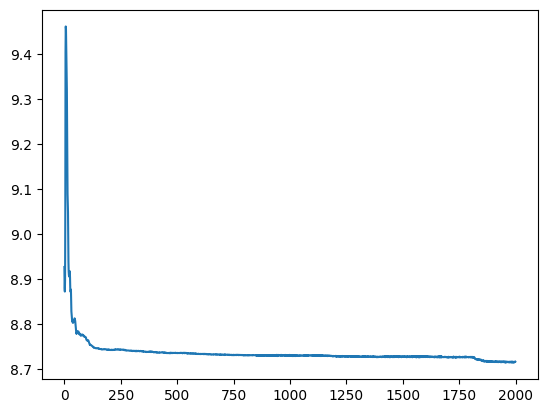

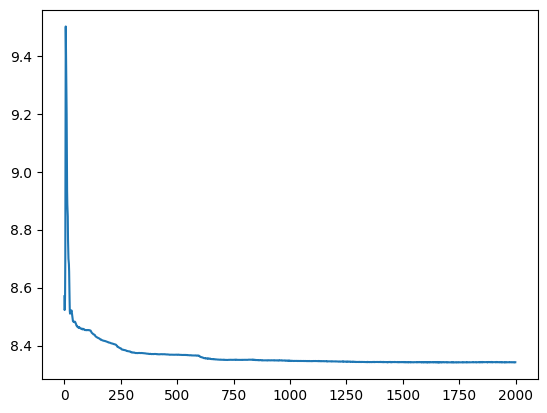

In [ ]:
# BASELINE

threshold_fn = SurrogateHeaviside.apply
model = ThresholdModel(threshold_fn=threshold_fn, device=device, t=.5, sigma=1., num_labels=num_labels, use_dense=False)
criterion = torch.nn.CrossEntropyLoss()

train_thresholding_model(model=model, 
                         predictions=baseline_pred_labels_train,
                         labels=true_labels_train,
                         epochs=2000, 
                         criterion=criterion, 
                         num_labels=num_labels,
                         lr=1e-01,
                         verbose=False
                         )
learned_thresholds=model.thresh.clone().detach().cpu().numpy()
sigma = model.sigma.clone().detach().cpu().numpy()
print(f'learned_thresholds BASELINE: \n{learned_thresholds}')

# BASELINE AUGMENTATION
threshold_fn = SurrogateHeaviside.apply
model = ThresholdModel(threshold_fn=threshold_fn, device=device, t=.5, sigma=1., num_labels=num_labels, use_dense=False)
criterion = torch.nn.CrossEntropyLoss()

train_thresholding_model(model=model, 
                         predictions=baseline_aug_pred_labels_train,
                         labels=true_labels_train,
                         epochs=2000, 
                         criterion=criterion, 
                         num_labels=num_labels,
                         lr=1e-01,
                         verbose=False
                         )
learned_thresholds=model.thresh.clone().detach().cpu().numpy()
sigma = model.sigma.clone().detach().cpu().numpy()
print(f'learned_thresholds BASELINE AUG: \n{learned_thresholds}')

#### Train

In [ ]:
print_classification_report_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.86      0.82      0.84       804
    Self-direction: action       0.93      0.78      0.85      1134
               Stimulation       0.64      0.33      0.44       196
                  Hedonism       0.84      0.67      0.74       137
               Achievement       0.92      0.84      0.88      1212
          Power: dominance       0.79      0.56      0.66       482
          Power: resources       0.94      0.85      0.89       496
                      Face       0.85      0.25      0.39       304
        Security: personal       0.94      0.87      0.90      1594
        Security: societal       0.92      0.87      0.90      1383
                 Tradition       0.94      0.78      0.85       454
         Conformity: rules       0.89      0.64      0.75       928
 Conformity: interpersonal       0.87      0.65      0.74       172
                  Humility       0.90      0.58

In [ ]:
print_classification_report_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.70      0.94      0.80       804
    Self-direction: action       0.79      0.91      0.85      1134
               Stimulation       0.20      0.87      0.32       196
                  Hedonism       0.29      0.96      0.44       137
               Achievement       0.82      0.92      0.87      1212
          Power: dominance       0.43      0.87      0.57       482
          Power: resources       0.72      0.97      0.83       496
                      Face       0.32      0.78      0.45       304
        Security: personal       0.89      0.91      0.90      1594
        Security: societal       0.87      0.93      0.90      1383
                 Tradition       0.75      0.94      0.84       454
         Conformity: rules       0.70      0.87      0.77       928
 Conformity: interpersonal       0.43      0.88      0.57       172
                  Humility       0.47      0.88

In [ ]:
print_classification_report_thresholding(true_labels_train, baseline_aug_pred_labels_train, labels_columns, threshold=learned_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.75      0.91      0.82       804
    Self-direction: action       0.80      0.91      0.85      1134
               Stimulation       0.46      0.57      0.51       196
                  Hedonism       0.72      0.77      0.74       137
               Achievement       0.83      0.91      0.87      1212
          Power: dominance       0.61      0.76      0.68       482
          Power: resources       0.86      0.95      0.90       496
                      Face       0.59      0.56      0.58       304
        Security: personal       0.85      0.93      0.89      1594
        Security: societal       0.84      0.94      0.89      1383
                 Tradition       0.84      0.91      0.87       454
         Conformity: rules       0.69      0.87      0.77       928
 Conformity: interpersonal       0.78      0.77      0.77       172
                  Humility       0.69      0.77

#### Test BASELINE


In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_pred_labels_test, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.72      0.43      0.54       251
    Self-direction: action       0.78      0.34      0.47       496
               Stimulation       0.80      0.03      0.06       138
                  Hedonism       0.67      0.10      0.17       103
               Achievement       0.75      0.54      0.63       575
          Power: dominance       0.67      0.10      0.17       164
          Power: resources       0.50      0.25      0.33       132
                      Face       0.00      0.00      0.00       130
        Security: personal       0.74      0.77      0.75       759
        Security: societal       0.61      0.60      0.61       488
                 Tradition       0.59      0.35      0.44       172
         Conformity: rules       0.58      0.50      0.54       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       0.38      0.02

In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.44      0.66      0.53       251
    Self-direction: action       0.58      0.58      0.58       496
               Stimulation       0.21      0.54      0.30       138
                  Hedonism       0.26      0.52      0.35       103
               Achievement       0.64      0.67      0.66       575
          Power: dominance       0.27      0.46      0.34       164
          Power: resources       0.36      0.72      0.48       132
                      Face       0.17      0.40      0.24       130
        Security: personal       0.68      0.83      0.75       759
        Security: societal       0.52      0.71      0.60       488
                 Tradition       0.38      0.51      0.43       172
         Conformity: rules       0.43      0.81      0.56       455
 Conformity: interpersonal       0.18      0.48      0.27        60
                  Humility       0.11      0.39

In [ ]:
baseline_report = print_classification_report_thresholding(true_labels_test, baseline_pred_labels_test, labels_columns, threshold=learned_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.52      0.58      0.55       251
    Self-direction: action       0.59      0.56      0.57       496
               Stimulation       0.56      0.13      0.21       138
                  Hedonism       0.67      0.14      0.23       103
               Achievement       0.65      0.67      0.66       575
          Power: dominance       0.38      0.27      0.32       164
          Power: resources       0.42      0.47      0.44       132
                      Face       0.15      0.05      0.07       130
        Security: personal       0.64      0.87      0.74       759
        Security: societal       0.50      0.75      0.60       488
                 Tradition       0.45      0.45      0.45       172
         Conformity: rules       0.42      0.82      0.56       455
 Conformity: interpersonal       0.30      0.05      0.09        60
                  Humility       0.17      0.15

#### Test BASELINE AUG


In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_aug_pred_labels_test, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.62      0.48      0.54       251
    Self-direction: action       0.67      0.46      0.55       496
               Stimulation       0.64      0.10      0.18       138
                  Hedonism       0.55      0.25      0.35       103
               Achievement       0.69      0.58      0.63       575
          Power: dominance       0.37      0.21      0.27       164
          Power: resources       0.43      0.34      0.38       132
                      Face       0.18      0.02      0.03       130
        Security: personal       0.75      0.76      0.76       759
        Security: societal       0.64      0.55      0.59       488
                 Tradition       0.61      0.33      0.43       172
         Conformity: rules       0.64      0.46      0.53       455
 Conformity: interpersonal       0.45      0.17      0.24        60
                  Humility       0.25      0.04

In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_aug_pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.43      0.66      0.52       251
    Self-direction: action       0.52      0.63      0.57       496
               Stimulation       0.20      0.55      0.30       138
                  Hedonism       0.27      0.60      0.37       103
               Achievement       0.62      0.70      0.66       575
          Power: dominance       0.22      0.51      0.31       164
          Power: resources       0.38      0.70      0.49       132
                      Face       0.20      0.48      0.28       130
        Security: personal       0.71      0.82      0.76       759
        Security: societal       0.56      0.65      0.60       488
                 Tradition       0.44      0.47      0.45       172
         Conformity: rules       0.53      0.70      0.60       455
 Conformity: interpersonal       0.16      0.52      0.25        60
                  Humility       0.15      0.28

In [ ]:
baseline_aug_report = print_classification_report_thresholding(true_labels_test, baseline_aug_pred_labels_test, labels_columns, threshold=learned_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.49      0.60      0.54       251
    Self-direction: action       0.53      0.62      0.57       496
               Stimulation       0.44      0.24      0.31       138
                  Hedonism       0.52      0.35      0.42       103
               Achievement       0.63      0.69      0.66       575
          Power: dominance       0.31      0.38      0.34       164
          Power: resources       0.40      0.53      0.46       132
                      Face       0.27      0.15      0.19       130
        Security: personal       0.68      0.85      0.76       759
        Security: societal       0.54      0.68      0.60       488
                 Tradition       0.51      0.42      0.46       172
         Conformity: rules       0.53      0.71      0.61       455
 Conformity: interpersonal       0.27      0.25      0.26        60
                  Humility       0.18      0.15

#### Test BASELINE TRANSFER LEARNING


In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_tl_pred_labels_test, labels_columns, threshold=MANUAL_THRESHOLD)

                            precision    recall  f1-score   support

   Self-direction: thought       0.00      0.00      0.00       251
    Self-direction: action       0.58      0.01      0.03       496
               Stimulation       0.00      0.00      0.00       138
                  Hedonism       0.00      0.00      0.00       103
               Achievement       0.71      0.22      0.34       575
          Power: dominance       0.00      0.00      0.00       164
          Power: resources       0.00      0.00      0.00       132
                      Face       0.00      0.00      0.00       130
        Security: personal       0.69      0.50      0.58       759
        Security: societal       0.65      0.15      0.24       488
                 Tradition       0.65      0.06      0.12       172
         Conformity: rules       0.40      0.03      0.05       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       0.00      0.00

In [ ]:
baseline_tl_report = print_classification_report_thresholding(true_labels_test, baseline_tl_pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.24      0.71      0.36       251
    Self-direction: action       0.31      0.84      0.45       496
               Stimulation       0.08      0.58      0.14       138
                  Hedonism       0.04      0.28      0.07       103
               Achievement       0.44      0.70      0.54       575
          Power: dominance       0.15      0.47      0.23       164
          Power: resources       0.22      0.70      0.33       132
                      Face       0.10      0.39      0.16       130
        Security: personal       0.56      0.87      0.68       759
        Security: societal       0.50      0.55      0.52       488
                 Tradition       0.21      0.62      0.32       172
         Conformity: rules       0.28      0.89      0.42       455
 Conformity: interpersonal       0.06      0.12      0.08        60
                  Humility       0.09      0.35

In [ ]:
print_classification_report_thresholding(true_labels_test, baseline_tl_pred_labels_test, labels_columns, threshold=learned_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.28      0.25      0.26       251
    Self-direction: action       0.31      0.80      0.45       496
               Stimulation       0.00      0.00      0.00       138
                  Hedonism       0.00      0.00      0.00       103
               Achievement       0.46      0.63      0.53       575
          Power: dominance       0.44      0.02      0.05       164
          Power: resources       0.27      0.02      0.04       132
                      Face       0.17      0.01      0.01       130
        Security: personal       0.47      0.95      0.63       759
        Security: societal       0.43      0.68      0.53       488
                 Tradition       0.26      0.37      0.31       172
         Conformity: rules       0.27      0.89      0.42       455
 Conformity: interpersonal       0.00      0.00      0.00        60
                  Humility       0.10      0.06

## Error Analysis

In [34]:
import pickle
with open('/content/human-value-detection/baseling_bert_base_reports.pkl', 'rb') as f:
    baseling_bert_base_reports = pickle.load(f)

with open('/content/human-value-detection/baseling_mpnet_base_reports.pkl', 'rb') as f:
    baseling_mpnet_base_reports = pickle.load(f)

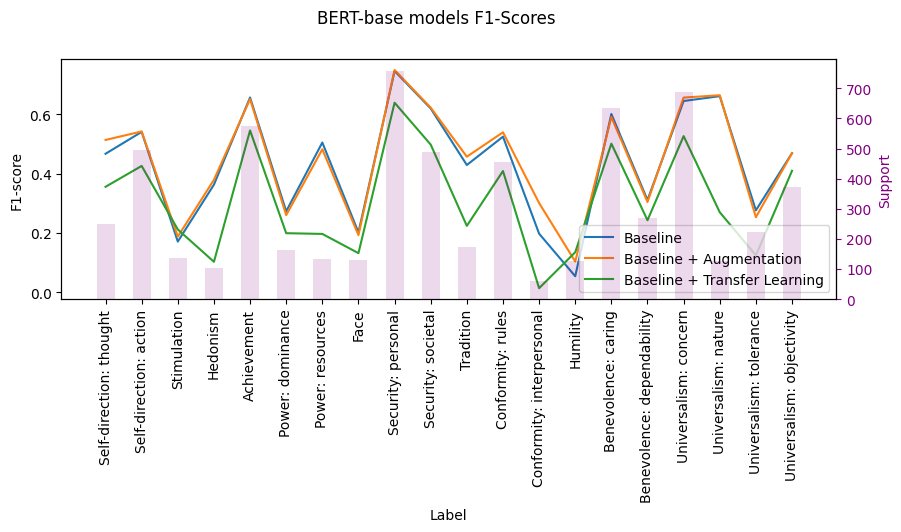

In [37]:
names = ['Baseline', 'Baseline + Augmentation', 'Baseline + Transfer Learning']
plot_classification_reports(baseling_bert_base_reports, names, 'BERT-base models F1-Scores')

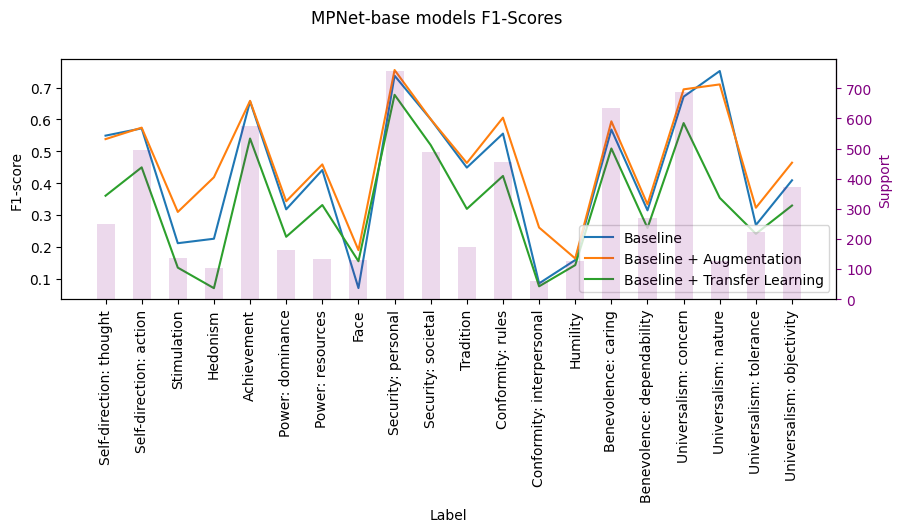

In [38]:
names = ['Baseline', 'Baseline + Augmentation', 'Baseline + Transfer Learning']
plot_classification_reports(baseling_mpnet_base_reports, names, 'MPNet-base models F1-Scores')